# Importing necessary library

In [1]:
import sys
sys.path.insert(0, '../src')
from terminal_script import read_data
from terminal_script import plot_top_10_by_state
from terminal_script import two_sample_t_test
from terminal_script import t_test_against_others
from terminal_script import t_test_weather_quan
from terminal_script import t_test_weather_city
from terminal_script import airline_t_test
import importlib
importlib.reload(sys.modules['terminal_script'])

<module 'terminal_script' from '../src/terminal_script.py'>

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Rolling 12-months data

In [3]:
df_02 = read_data('../data/2019_02_ALL.csv')
df_03 = read_data('../data/2019_03_ALL.csv')
df_04 = read_data('../data/2019_04_ALL.csv')
df_05 = read_data('../data/2019_05_ALL.csv')
df_06 = read_data('../data/2019_06_ALL.csv')
df_07 = read_data('../data/2019_07_ALL.csv')
df_08 = read_data('../data/2019_08_ALL.csv')
df_09 = read_data('../data/2019_09_ALL.csv')
df_10 = read_data('../data/2019_10_ALL.csv')
df_11 = read_data('../data/2019_11_ALL.csv')
df_12 = read_data('../data/2019_12_ALL.csv')
df_01 = read_data('../data/2020_01_ALL.csv')

In [4]:
frames = [df_02,df_03,df_04,df_05,df_06,df_07,df_08,df_09,df_10,df_11,df_12,df_01]

In [5]:
df_one_year = pd.concat(frames)

# Airline

In [158]:
print(df_one_year['OP_UNIQUE_CARRIER'].unique())
print(df_one_year['OP_UNIQUE_CARRIER'].nunique())

['AA' 'WN' '9E' 'OH' 'B6' 'NK' 'MQ' 'G4' 'YV' 'DL' 'HA' 'OO' 'UA' 'AS'
 'YX' 'EV' 'F9']
17


In [21]:
airline_pivot = df_one_year.groupby(['ORIGIN_CITY_NAME','OP_UNIQUE_CARRIER']).agg(
    total_flight=pd.NamedAgg(column='OP_UNIQUE_CARRIER',aggfunc='count'),
    total_delay_min=pd.NamedAgg(column='DEP_DELAY',aggfunc='sum'),
    total_dist=pd.NamedAgg(column='DISTANCE',aggfunc='sum'),
    cancelled_count=pd.NamedAgg(column='CANCELLED',aggfunc='sum'),
).reset_index()

In [245]:
airline_pivot

,ORIGIN_CITY_NAME,OP_UNIQUE_CARRIER,total_flight,total_delay_min,total_dist,cancelled_count
0,"Aberdeen, SD",OO,750,12778.0,192750.0,18.0
1,"Abilene, TX",MQ,2270,22259.0,358660.0,41.0
2,"Adak Island, AK",AS,104,1663.0,123968.0,6.0
3,"Aguadilla, PR",B6,1260,15846.0,1574649.0,10.0
4,"Aguadilla, PR",NK,678,5783.0,717981.0,10.0
...,...,...,...,...,...,...
1941,"Worcester, MA",OO,170,2336.0,99960.0,1.0
1942,"Wrangell, AK",AS,724,-1182.0,40906.0,14.0
1943,"Yakutat, AK",AS,722,-3855.0,148371.0,24.0
1944,"Yuma, AZ",OO,1547,5624.0,539738.0,6.0


In [22]:
carrier_decode = pd.read_csv('../data/carrier_decode.csv')
carrier_decode.rename(columns={'UNIQUE_CARRIER':'OP_UNIQUE_CARRIER'}, inplace=True)
carrier_decode.drop(axis=1,columns=['Unnamed: 2'],inplace=True)
carrier_decode.drop_duplicates(inplace=True)
carrier_decode

,OP_UNIQUE_CARRIER,UNIQUE_CARRIER_NAME
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.
...,...,...
2656,ZW,Air Wisconsin Airlines Corp
2660,ZX,Air Georgian
2661,ZX (1),Airbc Ltd.
2662,ZY,Atlantic Gulf Airlines


In [23]:
airline_merge = airline_pivot.merge(carrier_decode,on="OP_UNIQUE_CARRIER",how='left')
airline_merge

,ORIGIN_CITY_NAME,OP_UNIQUE_CARRIER,total_flight,total_delay_min,total_dist,cancelled_count,UNIQUE_CARRIER_NAME
0,"Aberdeen, SD",OO,750,12778.0,192750.0,18.0,SkyWest Airlines Inc.
1,"Abilene, TX",MQ,2270,22259.0,358660.0,41.0,Envoy Air
2,"Adak Island, AK",AS,104,1663.0,123968.0,6.0,Alaska Airlines Inc.
3,"Aguadilla, PR",B6,1260,15846.0,1574649.0,10.0,JetBlue Airways
4,"Aguadilla, PR",NK,678,5783.0,717981.0,10.0,Spirit Air Lines
...,...,...,...,...,...,...,...
1941,"Worcester, MA",OO,170,2336.0,99960.0,1.0,SkyWest Airlines Inc.
1942,"Wrangell, AK",AS,724,-1182.0,40906.0,14.0,Alaska Airlines Inc.
1943,"Yakutat, AK",AS,722,-3855.0,148371.0,24.0,Alaska Airlines Inc.
1944,"Yuma, AZ",OO,1547,5624.0,539738.0,6.0,SkyWest Airlines Inc.


In [24]:
airline_merge_pivot_ = airline_merge.groupby('UNIQUE_CARRIER_NAME').agg(
    airline_flight_ct=pd.NamedAgg(column='total_flight',aggfunc='sum'),
    airline_dist=pd.NamedAgg(column='total_dist',aggfunc='sum'),
    airline_delay_min=pd.NamedAgg(column='total_delay_min',aggfunc='sum'),
    airline_cancel_ct=pd.NamedAgg(column='cancelled_count',aggfunc='sum')
).reset_index()
airline_merge_pivot_['cancel_rate'] = airline_merge_pivot_['airline_cancel_ct'] / airline_merge_pivot_['airline_flight_ct']
airline_merge_pivot_['avg_delay'] = airline_merge_pivot_['airline_delay_min'] / airline_merge_pivot_['airline_flight_ct']
airline_merge_pivot_['avg_dist'] = airline_merge_pivot_['airline_dist'] / airline_merge_pivot_['airline_flight_ct']
airline_merge_pivot_

,UNIQUE_CARRIER_NAME,airline_flight_ct,airline_dist,airline_delay_min,airline_cancel_ct,cancel_rate,avg_delay,avg_dist
0,Alaska Airlines Inc.,265182,3.487865e+08,1370157.0,2920.0,0.011011,5.166855,1315.272002
1,Allegiant Air,106316,9.209710e+07,1053891.0,660.0,0.006208,9.912817,866.258136
2,American Airlines Inc.,946035,9.379465e+08,11224981.0,19325.0,0.020427,11.865291,991.450091
3,Delta Air Lines Inc.,998217,8.957706e+08,7863497.0,1555.0,0.001558,7.877543,897.370643
4,Endeavor Air Inc.,260002,1.199874e+08,2473578.0,3992.0,0.015354,9.513688,461.486258
5,Envoy Air,327508,1.467867e+08,2912649.0,10325.0,0.031526,8.893367,448.192777
6,ExpressJet Airlines LLC,132052,6.056856e+07,2071060.0,5269.0,0.039901,15.683670,458.672016
7,Frontier Airlines Inc.,138363,1.422820e+08,1878955.0,2275.0,0.016442,13.579895,1028.324408
8,Hawaiian Airlines Inc.,84128,6.361242e+07,103551.0,147.0,0.001747,1.230874,756.138539
9,JetBlue Airways,297677,3.321874e+08,4868483.0,2802.0,0.009413,16.354918,1115.932222


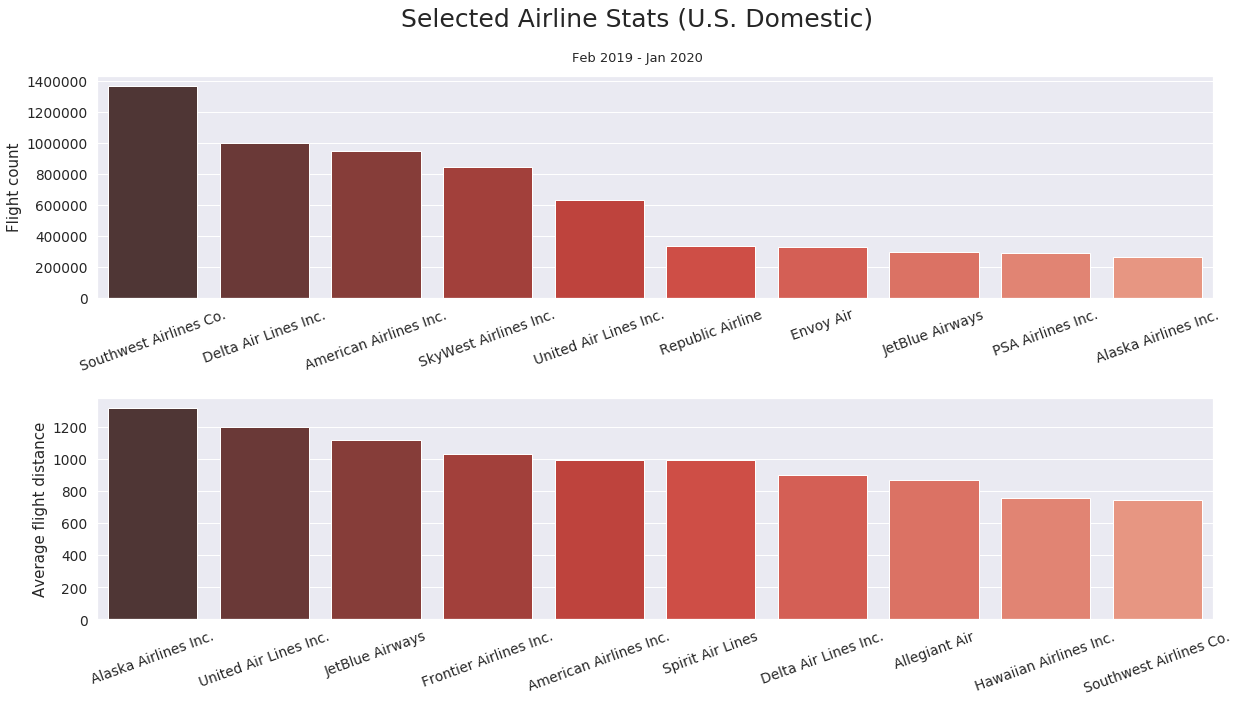

In [262]:
fig, axes = plt.subplots(2,1,figsize=(20,10))
sns.set(font_scale=1.25)

count = sns.barplot(x='UNIQUE_CARRIER_NAME',y='airline_flight_ct',data=airline_merge_pivot_.sort_values('airline_flight_ct', ascending=False)[0:10],palette='Reds_d',ax=axes[0])
dist = sns.barplot(x='UNIQUE_CARRIER_NAME',y='avg_dist',data=airline_merge_pivot_.sort_values('avg_dist', ascending=False)[0:10],palette='Reds_d',ax=axes[1])
# cancel = sns.barplot(x='UNIQUE_CARRIER_NAME',y='cancel_rate',data=airline_merge_pivot_.sort_values('cancel_rate', ascending=False),palette='Reds_d',ax=axes[1])
# delay = sns.barplot(x='UNIQUE_CARRIER_NAME',y='avg_delay',data=airline_merge_pivot_.sort_values('avg_delay', ascending=False),palette='Reds_d',ax=axes[2])

axes[0].set_ylabel('Flight count')
axes[1].set_ylabel('Average flight distance')
# axes[1].set_ylabel('Cancellation rate')
# axes[2].set_ylabel('Average delay (mins)')

for ax in fig.axes:
    ax.set_xlabel(' ')
    plt.setp(ax.get_xticklabels(), rotation=20, horizontalalignment='center')

plt.figtext(.5,.95,'Selected Airline Stats (U.S. Domestic)', fontsize=25, ha='center')
plt.figtext(.5,.9,'Feb 2019 - Jan 2020', fontsize=13, ha='center')
plt.subplots_adjust(hspace = 0.45)

# fig.savefig('img/airline_most_flight.png')

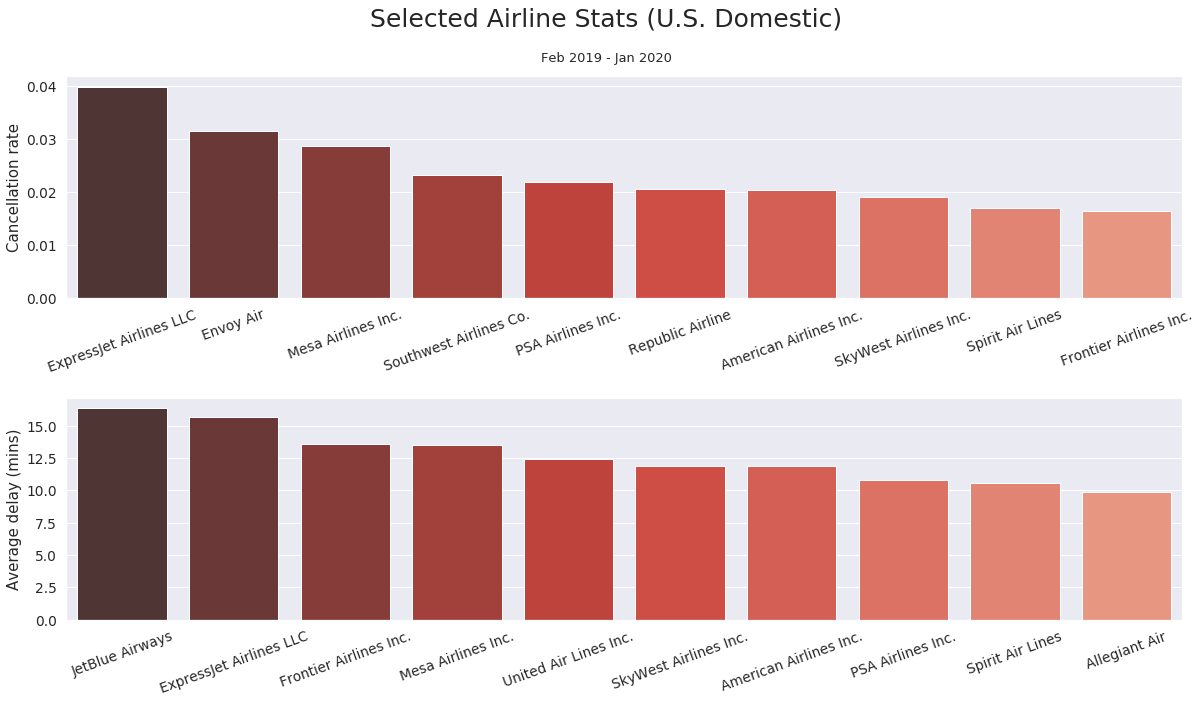

In [267]:
fig, axes = plt.subplots(2,1,figsize=(20,10))
sns.set(font_scale=1.25)

cancel = sns.barplot(x='UNIQUE_CARRIER_NAME',y='cancel_rate',data=airline_merge_pivot_.sort_values('cancel_rate', ascending=False)[0:10],palette='Reds_d',ax=axes[0])
delay = sns.barplot(x='UNIQUE_CARRIER_NAME',y='avg_delay',data=airline_merge_pivot_.sort_values('avg_delay', ascending=False)[0:10],palette='Reds_d',ax=axes[1])

axes[0].set_ylabel('Cancellation rate')
axes[1].set_ylabel('Average delay (mins)')

for ax in fig.axes:
    ax.set_xlabel(' ')
    plt.setp(ax.get_xticklabels(), rotation=20, horizontalalignment='center')

plt.figtext(.5,.95,'Selected Airline Stats (U.S. Domestic)', fontsize=25, ha='center')
plt.figtext(.5,.9,'Feb 2019 - Jan 2020', fontsize=13, ha='center')
plt.subplots_adjust(hspace = 0.45)

# fig.savefig('img/airline_cancel_delay.png')

In [26]:
city_filter = ['San Francisco, CA']
airline_merge_pivot_sfo = airline_merge[airline_merge['ORIGIN_CITY_NAME'].isin(city_filter)].groupby('UNIQUE_CARRIER_NAME').agg(
    airline_flight_ct=pd.NamedAgg(column='total_flight',aggfunc='sum'),
    airline_cancel_ct=pd.NamedAgg(column='cancelled_count',aggfunc='sum'),
    airline_delay_sum=pd.NamedAgg(column='total_delay_min',aggfunc='sum'),
    airline_dist_sum=pd.NamedAgg(column='total_dist',aggfunc='sum'),
).reset_index()
airline_merge_pivot_sfo['cancel_rate'] = airline_merge_pivot_sfo['airline_cancel_ct'] / airline_merge_pivot_sfo['airline_flight_ct']
airline_merge_pivot_sfo['avg_delay'] = airline_merge_pivot_sfo['airline_delay_sum'] / airline_merge_pivot_sfo['airline_flight_ct']
airline_merge_pivot_sfo['avg_dist'] = airline_merge_pivot_sfo['airline_dist_sum'] / airline_merge_pivot_sfo['airline_flight_ct']
airline_merge_pivot_sfo

,UNIQUE_CARRIER_NAME,airline_flight_ct,airline_cancel_ct,airline_delay_sum,airline_dist_sum,cancel_rate,avg_delay,avg_dist
0,Alaska Airlines Inc.,22603,432.0,192227.0,26295242.0,0.019113,8.504491,1163.351856
1,American Airlines Inc.,13657,321.0,204180.0,24158848.0,0.023504,14.950575,1768.971809
2,Delta Air Lines Inc.,15316,5.0,168697.0,22887679.0,0.000326,11.014429,1494.363998
3,Frontier Airlines Inc.,1516,28.0,38002.0,1775698.0,0.018470,25.067282,1171.304749
4,Hawaiian Airlines Inc.,834,12.0,6858.0,1978032.0,0.014388,8.223022,2371.741007
5,JetBlue Airways,5339,8.0,72009.0,12449632.0,0.001498,13.487357,2331.828432
6,SkyWest Airlines Inc.,39988,1469.0,614450.0,22480623.0,0.036736,15.365860,562.184230
7,Southwest Airlines Co.,14599,737.0,160167.0,9021989.0,0.050483,10.971094,617.986780
8,United Air Lines Inc.,57061,225.0,726353.0,85169810.0,0.003943,12.729412,1492.609839


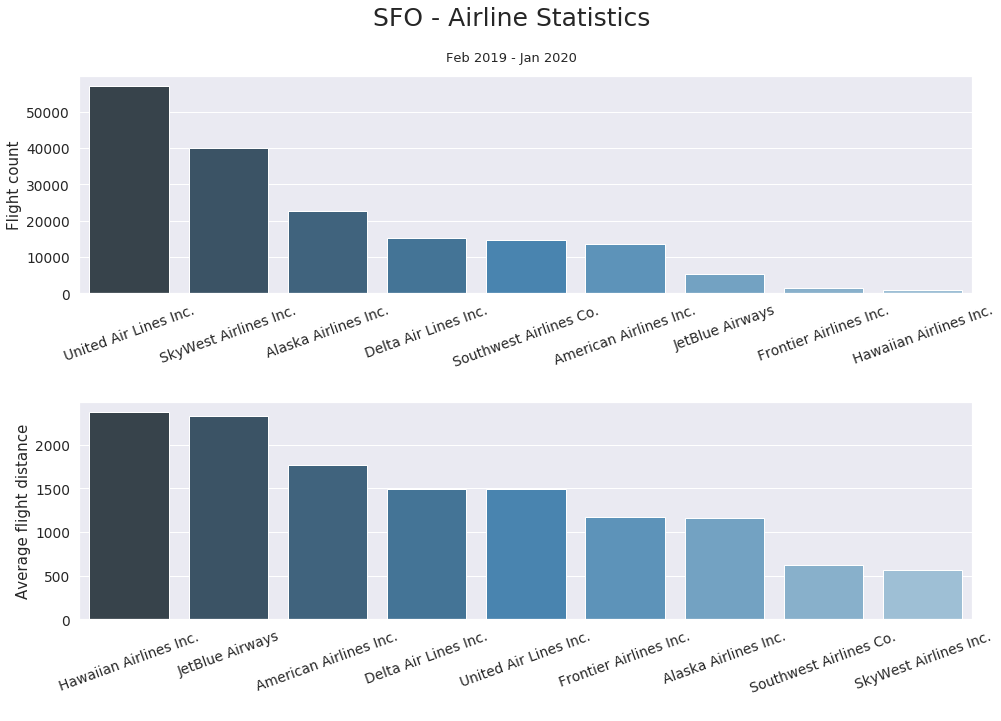

In [377]:
fig, axes = plt.subplots(2,1,figsize=(16,10))
sns.set(font_scale=1.25)

count = sns.barplot(x='UNIQUE_CARRIER_NAME',y='airline_flight_ct',data=airline_merge_pivot_sfo.sort_values('airline_flight_ct', ascending=False),palette='Blues_d',ax=axes[0])
rate = sns.barplot(x='UNIQUE_CARRIER_NAME',y='avg_dist',data=airline_merge_pivot_sfo.sort_values('avg_dist', ascending=False),palette='Blues_d',ax=axes[1])

axes[0].set_xlabel(' ')
axes[0].set_ylabel('Flight count')
axes[1].set_xlabel(' ')
axes[1].set_ylabel('Average flight distance')

for ax in fig.axes:
    ax.set_xlabel(' ')
    plt.setp(ax.get_xticklabels(), rotation=20, horizontalalignment='center')

plt.figtext(.5,.95,'SFO - Airline Statistics', fontsize=25, ha='center')
plt.figtext(.5,.9,'Feb 2019 - Jan 2020', fontsize=13, ha='center')

plt.subplots_adjust(hspace = 0.5)
plt.savefig('../img/airline_SFO_1.png', bbox_inches = "tight")

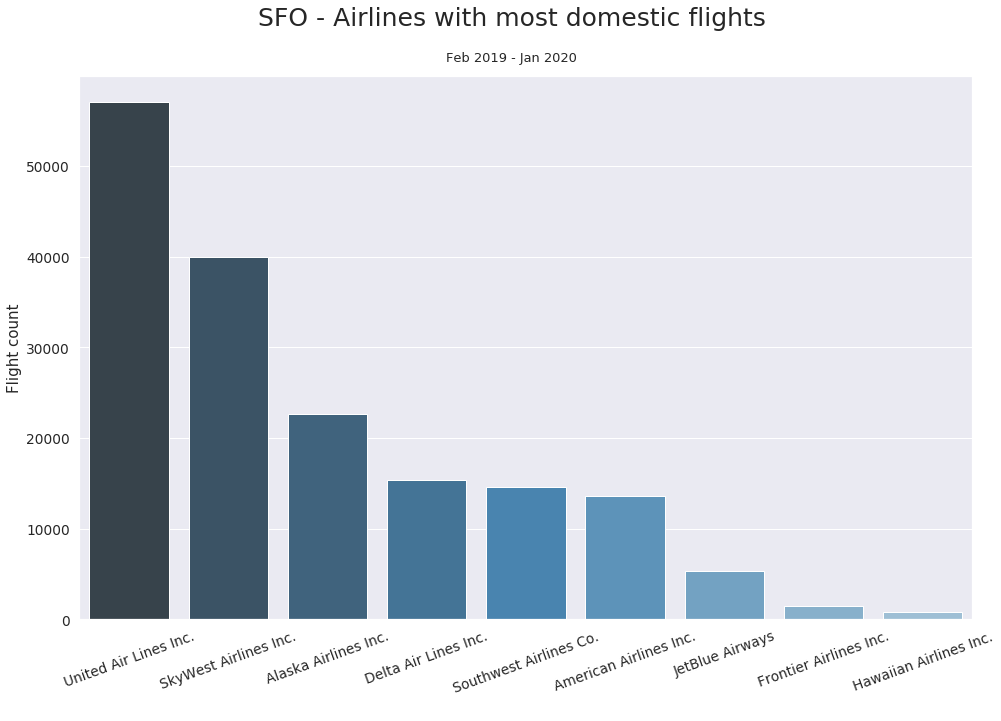

In [29]:
fig, axes = plt.subplots(figsize=(16,10))
sns.set(font_scale=1.25)

count = sns.barplot(x='UNIQUE_CARRIER_NAME',y='airline_flight_ct',data=airline_merge_pivot_sfo.sort_values('airline_flight_ct', ascending=False),palette='Blues_d')

axes.set_xlabel(' ')
axes.set_ylabel('Flight count')

for ax in fig.axes:
    ax.set_xlabel(' ')
    plt.setp(ax.get_xticklabels(), rotation=20, horizontalalignment='center')

plt.figtext(.5,.95,'SFO - Airlines with most domestic flights', fontsize=25, ha='center')
plt.figtext(.5,.9,'Feb 2019 - Jan 2020', fontsize=13, ha='center')

plt.subplots_adjust(hspace = 0.5)
plt.savefig('../img/airline_SFO_2.png', bbox_inches = "tight")

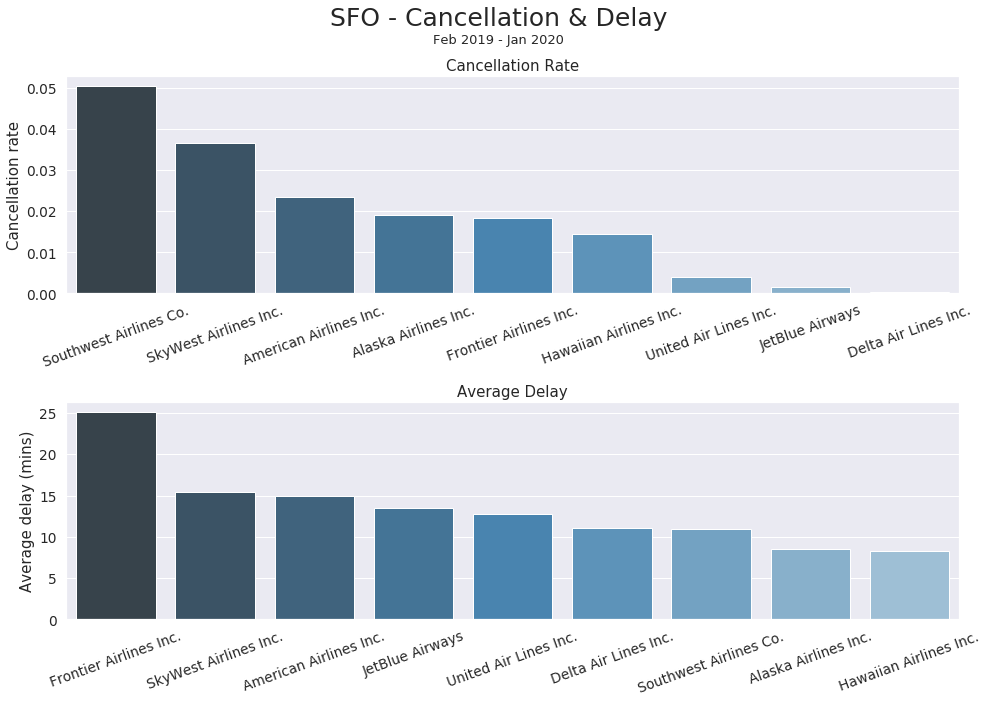

In [32]:
fig, axes = plt.subplots(2,1,figsize=(16,10))
sns.set(font_scale=1.25)

cancel = sns.barplot(x='UNIQUE_CARRIER_NAME',y='cancel_rate',data=airline_merge_pivot_sfo.sort_values('cancel_rate', ascending=False),palette='Blues_d',ax=axes[0])
rate = sns.barplot(x='UNIQUE_CARRIER_NAME',y='avg_delay',data=airline_merge_pivot_sfo.sort_values('avg_delay', ascending=False),palette='Blues_d',ax=axes[1])

axes[0].set_xlabel(' ')
axes[0].set_ylabel('Cancellation rate')
axes[0].set_title('Cancellation Rate')
axes[1].set_xlabel(' ')
axes[1].set_ylabel('Average delay (mins)')
axes[1].set_title('Average Delay')

for ax in fig.axes:
    ax.set_xlabel(' ')
    plt.setp(ax.get_xticklabels(), rotation=20, horizontalalignment='center')

plt.figtext(.5,.95,'SFO - Cancellation & Delay', fontsize=25, ha='center')
plt.figtext(.5,.925,'Feb 2019 - Jan 2020', fontsize=13, ha='center')

plt.subplots_adjust(hspace = 0.5)
plt.savefig('../img/airline_SFO_3.png', bbox_inches = "tight")

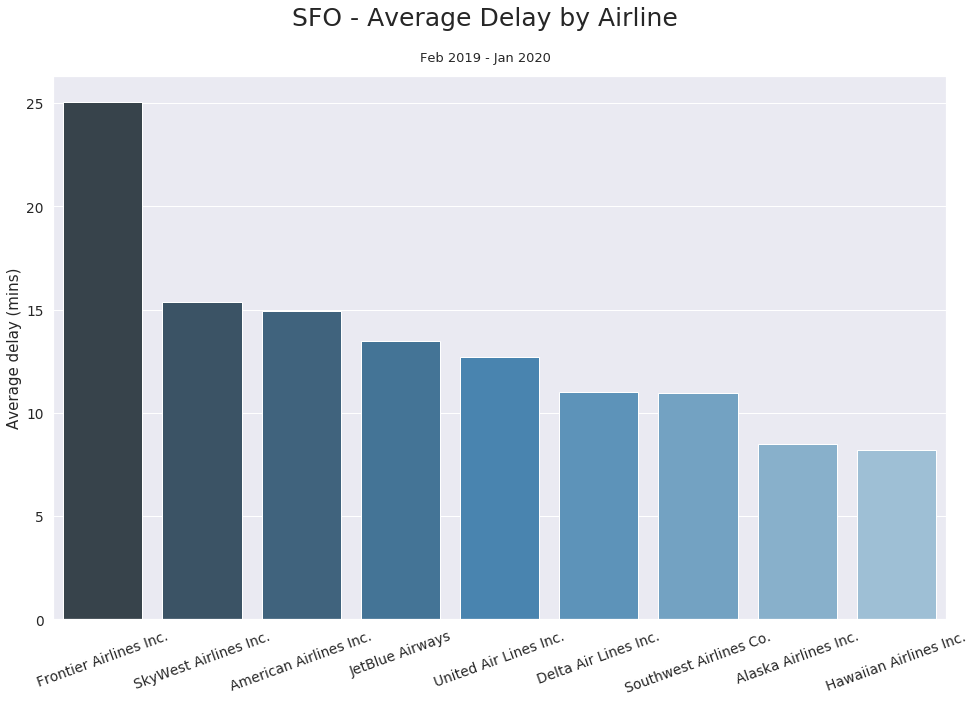

In [36]:
fig, axes = plt.subplots(figsize=(16,10))
sns.set(font_scale=1.25)

rate = sns.barplot(x='UNIQUE_CARRIER_NAME',y='avg_delay',data=airline_merge_pivot_sfo.sort_values('avg_delay', ascending=False),palette='Blues_d')

axes.set_xlabel(' ')
axes.set_ylabel('Average delay (mins)')

for ax in fig.axes:
    ax.set_xlabel(' ')
    plt.setp(ax.get_xticklabels(), rotation=20, horizontalalignment='center')

plt.figtext(.5,.95,'SFO - Average Delay by Airline', fontsize=25, ha='center')
plt.figtext(.5,.9,'Feb 2019 - Jan 2020', fontsize=13, ha='center')

plt.subplots_adjust(hspace = 0.5)
plt.savefig('../img/airline_SFO_4.png', bbox_inches = "tight")

# Airline hypothesis testing

In [37]:
df_ = df_one_year
city1 = 'San Francisco, CA'
city2 = 'San Francisco, CA'
airline1 = 'F9'
airline2 = 'OO'
col = 'DEP_DELAY'

N1, N2, s1mean, s2mean, a_b_std, t_score, p_val = airline_t_test(df_, city1, city2, airline1, airline2, col)
print(N1, N2)
print(s1mean, s2mean)
print(a_b_std)
print(t_score, p_val / 2)

1489 38569
25.521826729348557 15.931188260001555
1.3221788846633853
7.253661800678878 3.096006422278701e-13


In [38]:
df_ = df_one_year
city1 = 'San Francisco, CA'
city2 = 'San Francisco, CA'
airline1 = 'F9'
airline2 = 'AA'
col = 'DEP_DELAY'

N1, N2, s1mean, s2mean, a_b_std, t_score, p_val = airline_t_test(df_, city1, city2, airline1, airline2, col)
print(N1, N2)
print(s1mean, s2mean)
print(a_b_std)
print(t_score, p_val / 2)

1489 13342
25.521826729348557 15.303552690751012
1.3984789071798451
7.306705868881203 1.9431027492049356e-13


In [39]:
df_ = df_one_year
city1 = 'San Francisco, CA'
city2 = 'San Francisco, CA'
airline1 = 'F9'
airline2 = 'B6'
col = 'DEP_DELAY'

N1, N2, s1mean, s2mean, a_b_std, t_score, p_val = airline_t_test(df_, city1, city2, airline1, airline2, col)
print(N1, N2)
print(s1mean, s2mean)
print(a_b_std)
print(t_score, p_val / 2)

1489 5331
25.521826729348557 13.507597073719753
1.4676200483156336
8.186198920774736 2.1378317817937018e-16


In [40]:
df_ = df_one_year
city1 = 'San Francisco, CA'
city2 = 'San Francisco, CA'
airline1 = 'F9'
airline2 = 'UA'
col = 'DEP_DELAY'

N1, N2, s1mean, s2mean, a_b_std, t_score, p_val = airline_t_test(df_, city1, city2, airline1, airline2, col)
print(N1, N2)
print(s1mean, s2mean)
print(a_b_std)
print(t_score, p_val / 2)

1489 56843
25.521826729348557 12.778231268581884
1.298855146903324
9.811406215042085 2.1782016172448777e-22


In [41]:
df_ = df_one_year
city1 = 'San Francisco, CA'
city2 = 'San Francisco, CA'
airline1 = 'F9'
airline2 = 'AS'
col = 'DEP_DELAY'

N1, N2, s1mean, s2mean, a_b_std, t_score, p_val = airline_t_test(df_, city1, city2, airline1, airline2, col)
print(N1, N2)
print(s1mean, s2mean)
print(a_b_std)
print(t_score, p_val / 2)

1489 22180
25.521826729348557 8.66668169522092
1.305084592534491
12.914982776246504 1.1952983474377127e-36


In [42]:
df_ = df_one_year
city1 = 'San Francisco, CA'
city2 = 'San Francisco, CA'
airline1 = 'F9'
airline2 = 'WN'
col = 'DEP_DELAY'

N1, N2, s1mean, s2mean, a_b_std, t_score, p_val = airline_t_test(df_, city1, city2, airline1, airline2, col)
print(N1, N2)
print(s1mean, s2mean)
print(a_b_std)
print(t_score, p_val/2)

1489 13863
25.521826729348557 11.553559835533434
1.3168753623121565
10.607129037094126 9.068895598722317e-26


check w/ scipy

In [415]:
df_ = df_one_year
city1 = 'San Francisco, CA'
city2 = 'San Francisco, CA'
airline1 = 'UA'
airline2 = 'WN'
col = 'DEP_DELAY'
a = df_[(df_['ORIGIN_CITY_NAME'] == city1) & (df_['OP_UNIQUE_CARRIER'] == airline1) & (df_[col].isnull() == False)][col]
b = df_[(df_['ORIGIN_CITY_NAME'] == city2) & (df_['OP_UNIQUE_CARRIER'] == airline2) & (df_[col].isnull() == False)][col]
scs.ttest_ind(a,b,equal_var=False)

Ttest_indResult(statistic=3.6176053707798816, pvalue=0.00029788955374045276)